# Riverstone NLP Test

 This test is designed to ascertain a candidate’s competency in Python to manipulate data, processes and  analyze text, and produce a simple R-Shiny application to explore results. Ability to communicate  through visualized output is important as well. Lastly, candidates must be able to explain the rationale for  processing and modeling decisions both through thorough documentation and discussion. 

In [10]:
# Title: RiverStone NLP Test
# Author: Tadhg Lynch
# Date: 2023-4-14

## Data 
Download the csv here https://www.kaggle.com/rootuser/worldnews-on-reddit 


In [11]:
# packages
import pandas as pd

#import data
df = pd.read_csv("data/reddit_worldnews_start_to_2016-11-22.csv")

# From kaggle:

# Reddit is a social network which divide topics into so called 'subreddits'.
# In subreddit 'worldnews', news of the whole world are published. The dataset contains following columns:
# time_created - a Unix timestamp of the submission creation date
# date_created - creation time in %Y-%m-%d
# up_votes - how often the submission was upvoted
# down_votes - how often the submission was downvoted
# title - the title of the submission
# over_18 - if the submission is for mature persons
# author - the reddit username of the author
# subreddit - this is always 'worldnews'

df.info() # non-nulls across the board, nice

# I like to see the data
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   subreddit     509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


## Request 1
Description: Build and graph a seasonal index of average upvotes by post at the Monthly, Day of Week, and Hour of  Day levels. 

In [84]:
# converting unix timestamp as will be needed for hourly
df['time_created'] = pd.to_datetime(df['time_created'], unit='s')

# check that new time_created matches date_created
matching = df['time_created'].dt.date == pd.to_datetime(df['date_created']).dt.date

# show df columns where matching is false
df[matching == False]


# There is a singular mismatched case that has been caused by a post being created at exactly midnight, so will be sticking with the converted unix timestamp
# despite not being shown, it has time of 00:00:00, so will be fine for hourly

# drop no longer needed date_created column
df = df.drop(['date_created'], axis=1)

,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
343260,2015-02-10,2015-02-09,7,0,Christians in India want their own Christian c...,False,InternetOfficer,worldnews


In [ ]:
# Function to graph seasonal index
def graph_seasonal_index(df, level):
    # group by level
    df_grouped = df.groupby(level)['up_votes'].mean()

    # graph seasonal index
    df_grouped.plot()

In [ ]:
graph_seasonal_index(df, df['time_created'].dt.month)

In [ ]:
graph_seasonal_index(df, df['time_created'].dt.dayofweek)

In [ ]:
graph_seasonal_index(df, df['time_created'].dt.hour)

## Request 2
Clean, scrub, and prepare post titles using standard NLP techniques. 

In [163]:
# The Subreddit posted rules:
# 1. No US Internal News or Politics
# 2. No Editorialized or Misleading Titles
# 3. No Feature stories
# 4. No Editorials, Opinion or Analysis Pieces
# 5. No Articles In Languages Other Than English
# 6. No Images, Videos or Audio Clips
# 7. No Bigotry or Other Offensive Content
# 8. No Personal Attacks On Other Users
# 9. No Memes, Gifs, unlabeled NSFW images
# 10. No Old News Articles (≥ 1 Week old)

# Main NLP Takeaways:
# no sentiment
# no other languages 
# unlikely to have poor grammar or misspellings (inferred by strict moderators)
# no emojis

# NLP ideas:
# Lots on Russia invasion of Ukraine, look out of more sparse references (e.g. Crimea, Moscow, Putin, etc.)... nevermind, dataset only goes up to 2016-11-22

In [151]:
# function to clean, scrub, and prepare post title using standard NLP techniques
def clean_post_title(post_title):
    # convert to lowercase
    post_title = post_title.lower()
    # remove numbers
    post_title = ''.join([i for i in post_title if not i.isdigit()])
    # remove single characters
    post_title = ' '.join([word for word in post_title.split() if len(word) > 1])
    # remove extra whitespace
    post_title = ' '.join(post_title.split())
    return post_title

clean_titles = df['title'].apply(clean_post_title)

# would apply more cleaning techniques, but OpenAI's models take care of this for us; in fact think what has been removed already may not be optimal as the model is designed to handle natural writing, so jumping to Request 3 and seeing how it goes before returning to this.

## Request 3
cluster post titles and identify the top 20 clusters by frequency. Use of Chat-GPT AI is encouraged. 

In [1]:
import pandas as pd
import numpy as np
import requests
import csv

#### Using OpenAI's API: https://platform.openai.com/docs/introduction/overview
##### Model Options:
![Model Options](.\images\openai-model-options.png)

In [ ]:
# Ada costs $0.0004/1000 tokens, 1 token is roughly 4 characters, so let's work out how much this will end up costing
titles = df['title'].tolist()

# get total number of characters
total_chars = 0
for title in titles:
    total_chars += len(title)

total_tokens = total_chars / 4
total_cost = total_tokens * 0.0004 / 1000
print("total_titles", len(titles))
print("total_chars:", total_chars)
print("total_tokens:", total_tokens)
print("total_cost:", total_cost)

In [30]:
# Set your OpenAI API key
api_key = "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

# Set the API endpoint and model name
endpoint = "https://api.openai.com/v1/embeddings"
model_name = "text-embedding-ada-002"

# Define your list of input strings
input_strings = titles

# Split input strings into batches
batch_size = 10000
input_string_batches = [input_strings[i:i+batch_size] for i in range(0, len(input_strings), batch_size)]

# Define the headers and data for the API request
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Create a CSV file to write embeddings
with open("embeddings.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)

    # Write header to the CSV file
    writer.writerow(["Input_String", "Embedding"])

    # Loop through input string batches
    for batch in input_string_batches:
        data = {
            "input": batch,
            "model": model_name
        }

        # Send the API request
        response = requests.post(endpoint, headers=headers, json=data)

        # Parse the response and extract the embeddings
        if response.status_code == 200:
            embeddings = response.json()["data"]

            # Write embeddings to the CSV file
            for i in range(len(batch)):
                writer.writerow([batch[i], embeddings[i]])
        else:
            print("Failed to get embeddings. Response code:", response.status_code)


In [9]:
# load data
datafile_path = "./data/embeddings.csv"
df = pd.read_csv(datafile_path)

# extract embedding from string
df["Embedding"] = [i['embedding'] for i in df.Embedding.apply(eval)]

matrix = np.vstack(df.Embedding.values)
matrix.shape

# save matrix as this takes about 15 minutes to run
np.save("./data/embeddings.npy", matrix)

In [2]:
# checkpoint
# load data
matrix = np.load("./data/embeddings.npy")
matrix.shape

(509236, 1536)

components: 1
components: 101
components: 201
components: 301
components: 401
components: 501


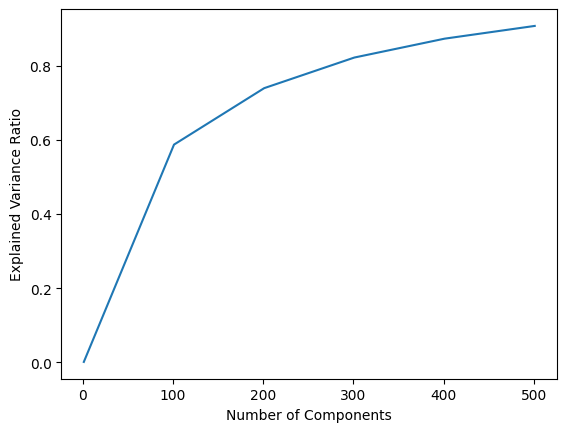

In [20]:
# 1536 dimensions is a lot, so let's try to reduce this with LSA
from sklearn.decomposition import TruncatedSVD

sample = np.random.choice(matrix.shape[0], 50000, replace=False)

components_list = [i for i in range(1, 600, 100)]
explained_variance_ratios = []
for components in components_list:
    print("components:", components)
    svd = TruncatedSVD(n_components=components)
    svd.fit(matrix[sample])
    explained_variance_ratios.append(svd.explained_variance_ratio_.sum())

# plot explained variance ratio
import matplotlib.pyplot as plt
plt.plot(components_list, explained_variance_ratios)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

100 components seems fine given how computationally intense later steps are going to be

In [3]:
# 100 components seems to be a good number
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)
svd.fit(matrix)
matrix_reduced = svd.transform(matrix)
matrix_reduced.shape

(509236, 100)

2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500


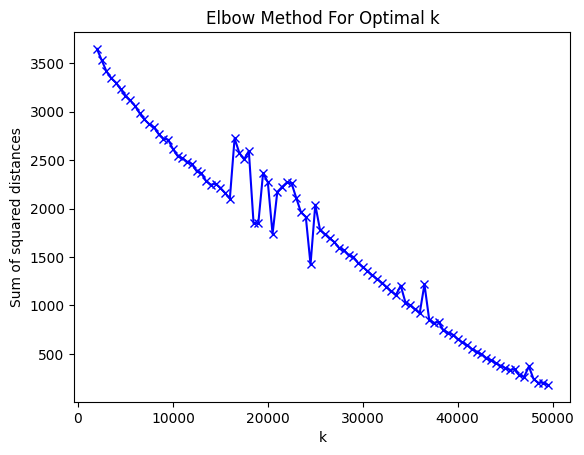

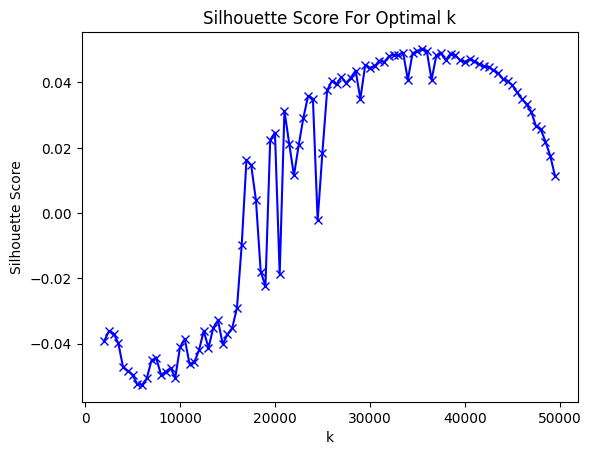

In [22]:
# Deciding on number of clusters for k-means using mini-batch k-means
# Elbow method & silhouette score
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# random sample
sample = np.random.choice(matrix_reduced.shape[0], 50000, replace=False)

# instead of random sample, take sequential sample as topics may be clustered together in time
sample = np.arange(0, 50000)

sum_of_squared_distances = []
silhouette_scores = []
K = range(2000, 50000, 500)
for k in K:
    print(k)
    km = MiniBatchKMeans(n_clusters=k, n_init=1) #setting n_init to 1 to speed up
    km = km.fit(matrix_reduced[sample])
    sum_of_squared_distances.append(km.inertia_)
    silhouette_scores.append(silhouette_score(matrix_reduced[sample], km.labels_))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

okay, not great as the clusters are so overlapping, but let's just go with 50% clusters for now a return to it later

In [51]:
# working with just first 25,000 titles for now to move things along

# load in df
# load data
datafile_path = "./data/reddit_worldnews_start_to_2016-11-22.csv"
df = pd.read_csv(datafile_path)

# cluster with batch k-means and 50% cluster size
from sklearn.cluster import MiniBatchKMeans
km = MiniBatchKMeans(n_clusters=40, batch_size=5000, n_init=10)
km.fit(matrix_reduced[:25000])

# chop to first 50,000 titles and append cluster labels
df = df.iloc[:25000]
df["cluster"] = km.labels_

In [ ]:
# let's visualize on a t-SNE plot
from sklearn.manifold import TSNE

x_tsne = TSNE(n_components=2, perplexity=30, n_iter=1000).fit_transform(matrix_reduced[:25000])

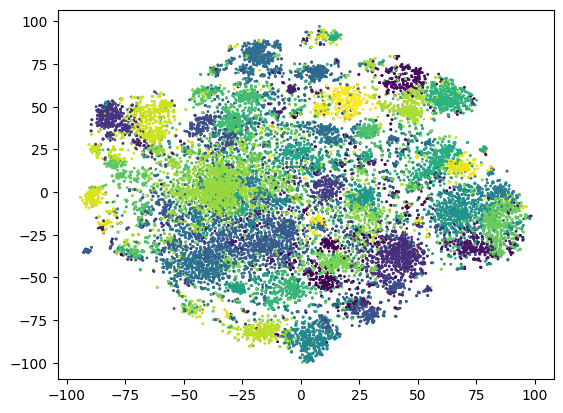

In [52]:
# scatter ploth with cluster labels
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=km.labels_, s=1)
# save out as 25000 with 12500 clusters
plt.savefig("./images/25000_40.png")
plt.show()

In [76]:
import openai
# making a pop up window to ask for your openai api key
import tkinter as tk
from tkinter import simpledialog

root = tk.Tk() # this is the pop up window
root.withdraw() # this hides the pop up window

# the input dialog
USER_INP = simpledialog.askstring(title="OpenAI API Key",
                                    prompt="What is your OpenAI API Key?")
openai.api_key = USER_INP


# Reading reviews from the top 20 clusters by size
rev_per_cluster = 5
n_clusters = 3

# get top 20 clusters by size
top_clusters = df.cluster.value_counts().index[:n_clusters]

# get top 5 reviews from each cluster
top_reviews = []
for cluster in top_clusters:
    top_reviews.append(df[df.cluster == cluster].title.values[:rev_per_cluster])

# print out
for i in range(n_clusters):
    reviews = "\n".join(
        df[df.cluster == top_clusters[i]].title.values[:rev_per_cluster]
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'The following reddit posts all have a shared topic, what do they have in common?\n\nReddit titles:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print("Cluster", i, "size:", df[df.cluster == top_clusters[i]].shape[0], "Theme:", response["choices"][0]["text"].replace("\n", ""))
    for j in range(rev_per_cluster):
        print(top_reviews[i][j])
    print("")

Cluster 0 size: 2095 Theme:  They all relate to current events and social issues.
Hay presto! Farmer unveils the  illegal  mock-Tudor castle he tried to hide behind 40ft hay bales
Nero-like Brown confirms King at last
Q&A: Chad rebellion
Modern Slavery: A world map
Smoking could kill 1billion in century

Cluster 1 size: 1103 Theme:  Politics in the United Kingdom
Archbishop of Canterbury calls for new law to punish  thoughtless or cruel  words -Times Online
Tony Blair calls in old allies over bid for EU job 
UK to Allow Wiretap Evidence in Court
BBC Readers mourn Castro s retirement!
Thatcher urges Tories to  hold firm on their beliefs  if they want to win back power

Cluster 2 size: 1036 Theme:  The US military presence in Iraq.
US says al-Qaida in Iraq using children
The Sons and Daughters of Iraq -video
No Local Allies in Wings for Mosul Fight - washingtonpost.com
Army Buried Study Faulting Iraq Planning - New York Times
U.S. bombing in Iraq massacring civilians, creating terrorists

In [10]:
# now trying with agglomerative hierachical clustering using ward linkage
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

sample = np.random.choice(matrix_reduced.shape[0], 2000, replace=False)
ac = linkage(matrix_reduced[sample], 'ward', optimal_ordering=True, )

<bound method _AxesBase.set_ylabel of <Axes: >>

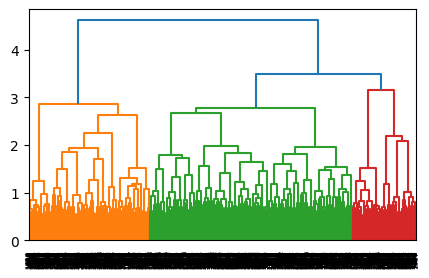

In [11]:
# visualise on dendrogram
fig, ax = plt.subplots(figsize=(5, 3)) # set size
dn = dendrogram(ac, ax=ax)
ax.set_ylabel

## Request 4
Build a simple, local web app displaying an interactive vizualization of the top 3 clusters from Request 3. 


In [134]:

!pip install shiny
!shiny create my_app
!shiny run --reload my_app/app.py


Created Shiny app at my_app\app.py


INFO:     Will watch for changes in these directories: ['C:\\Users\\JCAT\\Documents\\GitHub\\riverstone-nlp-test\\my_app']
ERROR:    [WinError 10013] An attempt was made to access a socket in a way forbidden by its access permissions


In [135]:
shiny.runExample("01_hello")

AttributeError: module 'shiny' has no attribute 'runExample'

In [141]:
pip install shiny

Note: you may need to restart the kernel to use updated packages.


In [150]:
mkdir python_shiny_example

In [151]:
cd python_shiny_example


c:\Users\JCAT\Documents\GitHub\riverstone-nlp-test\python_shiny_example\python_shiny_example\python_shiny_example\python_shiny_example


In [155]:
os.getcwd()

'C:\\Users\\JCAT'